In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

<Figure size 1000x700 with 0 Axes>

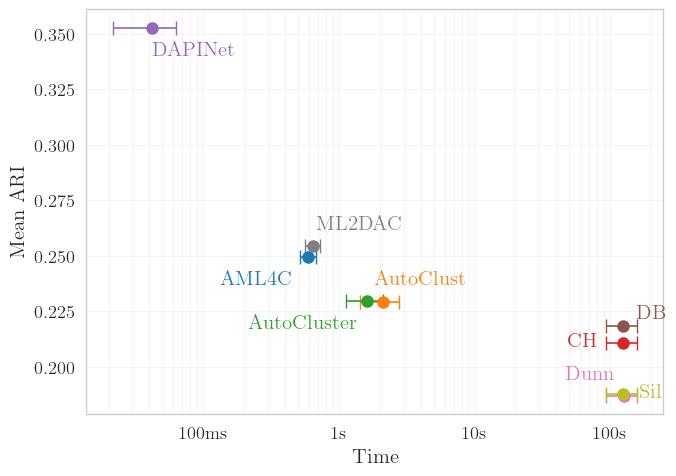

In [2]:
# 1. Load the dataset
# -------------------
df = pd.read_csv("results/full_results.csv")
df = df[
    ~df["dataset"].isin(
        ["mean", "median", "mse", "exact_best_count", "within_10pct_of_oracle_best_count"]
    )
].copy()

# 2. Preprocessing: Convert Wide format to Long format
# ----------------------------------------------------
# We need to extract algorithm name, ARI, and Time for each method for every dataset.

# Configuration mapping specific column prefixes to their time suffixes
methods_config = [
    ("oracle_best", "_time_ms"),
    ("DeepModel", "_time_ms"),
    ("ML2DAC_statistical+info-theory+general", "_time_ms"),
    ("AML4C_DBCV", "_time_ms"),
    ("AutoCluster_CH", "_time_ms"),
    ("AutoClust", "_time_ms"),
    ("davies_bouldin", "_time_ms_total"),
    ("calinski_harabasz", "_time_ms_total"),
    ("silhouette", "_time_ms_total"),
    ("dunn", "_time_ms_total"),
]

long_data = []

for index, row in df.iterrows():
    dataset_name = row["dataset"]
    for method, time_suffix in methods_config:
        # Construct column names based on patterns in the CSV
        algo_col = f"{method}_algorithm"
        ari_col = f"{method}_oracle_ari"
        time_col = f"{method}{time_suffix}"

        # specific check to ensure columns exist before accessing
        if algo_col in df.columns and ari_col in df.columns and time_col in df.columns:
            long_data.append(
                {
                    "Dataset": dataset_name,
                    "Method": method,
                    "Algorithm": row[algo_col],
                    "ARI": row[ari_col],
                    "Time_ms": row[time_col],
                }
            )

df_long = pd.DataFrame(long_data)

# 3. Clean up Method Names for the Plot
# -------------------------------------
name_mapping = {
    "ML2DAC_statistical+info-theory+general": "ML2DAC",
    "ML2DAC_statistical+general": "ML2DAC (S + G)",
    "oracle_best": "Oracle",
    "davies_bouldin": "DB",
    "calinski_harabasz": "CH",
    "silhouette": "Sil",
    "dunn": "Dunn",
    "DeepModel": "DAPINet",
    "AML4C_DBCV": "AML4C",
    "AML4C_COP": "AML4C (COP)",
    "AutoCluster_CH": "AutoCluster",
    "AutoCluster_DBI": "AutoCluster (DBI)",
    "AutoCluster_SIL": "AutoCluster (SIL)",
    "AutoClust": "AutoClust",
}

df_long["Method_Short"] = df_long["Method"].map(name_mapping).fillna(df_long["Method"])

# Remove rows with missing data
df_long_clean = df_long.dropna(subset=["ARI", "Time_ms"])

# 4. Calculate Statistics (Mean and Standard Error)
# -------------------------------------------------
stats = df_long_clean.groupby("Method_Short")[["ARI", "Time_ms"]].agg(["mean", "sem"])
# Flatten MultiIndex columns (e.g., ('ARI', 'mean') -> 'ARI_mean')
stats.columns = ["_".join(col) for col in stats.columns]
stats = stats.reset_index()

# 5. Generate the "Money Plot"
# ----------------------------
# Set style suitable for academic papers (ICML)
sns.set_context("paper", font_scale=1.5)
sns.set_style("whitegrid")

plt.figure(figsize=(10, 7))

# Color palette for consistent point/text colors
palette = sns.color_palette("tab10", n_colors=len(stats))
method_colors = dict(zip(stats["Method_Short"], palette))

# Per-label text offsets (x_mult scales x in log-space, y_add is additive)
text_offsets = {
    "DAPINet": {"x_mult": 4.1, "y_add": -0.01, "ha": "right", "va": "center"},
    "ML2DAC": {"x_mult": 4.5, "y_add": 0.01, "ha": "right", "va": "center"},
    "AML4C": {"x_mult": 0.75, "y_add": -0.01, "ha": "right", "va": "center"},
    "AutoClust": {"x_mult": 4.1, "y_add": 0.01, "ha": "right", "va": "center"},
    "AutoCluster": {"x_mult": 0.85, "y_add": -0.01, "ha": "right", "va": "center"},
    "Dunn": {"x_mult": 0.85, "y_add": 0.01, "ha": "right", "va": "center"},
    "CH": {"x_mult": 0.5, "y_add": 0.005, "ha": "center", "va": "top"},
    "DB": {"x_mult": 1.6, "y_add": 0.01, "ha": "center", "va": "top"},
    "Sil": {"x_mult": 1.6, "y_add": 0.005, "ha": "center", "va": "top"},
}

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
    }
)

plt.figure(figsize=(7, 5))

# Iterate through methods to plot them with error bars
for i, row in stats.iterrows():
    color = method_colors[row["Method_Short"]]
    plt.errorbar(
        x=row["Time_ms_mean"],
        y=row["ARI_mean"],
        xerr=row["Time_ms_sem"],
        fmt="o",  # Circle marker
        capsize=5,  # End caps on error bars
        markersize=8,
        label=row["Method_Short"],
        color=color,
    )

    # Add labels to the points with custom placement and matching color
    offsets = text_offsets.get(
        row["Method_Short"], {"x_mult": 1.1, "y_add": 0.005, "ha": "left", "va": "center"}
    )
    plt.annotate(
        row["Method_Short"],
        xy=(row["Time_ms_mean"], row["ARI_mean"]),
        xytext=(row["Time_ms_mean"] * offsets["x_mult"], row["ARI_mean"] + offsets["y_add"]),
        textcoords="data",
        fontsize=15,
        color=color,
        ha=offsets["ha"],
        va=offsets["va"],
    )

# Formatting axes
plt.xscale("log")  # Log scale is crucial for time
tick_positions = [100, 1000, 10000, 100000]  # 100ms, 1s, 10s, 100s in milliseconds
tick_labels = ["100ms", "1s", "10s", "100s"]
plt.xticks(tick_positions, tick_labels)
plt.xlabel("Time", fontsize=15)
plt.ylabel("Mean ARI", fontsize=15)
# plt.title("Performance vs. Time Efficiency", fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.savefig("results/figures/scatter_performance_time.pdf", dpi=600)
plt.show()